# InfoGAN

**Sem Q_loss no discriminador**

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.distributions import Multinomial
from torch.distributions.normal import Normal
from torch import nn
import matplotlib.pyplot as plt

---
* Funções de auxílio

In [2]:
def plots_dataset(X_tc):
    plt.figure(figsize=(20,7))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo')
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
#     plt.savefig('images/gan-4',quality=100)
    plt.show()

def plots_dims(X_tc,G_sample_plot):
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,1],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,0],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    plt.plot(G_sample_plot.data.numpy()[:,1],G_sample_plot.data.numpy()[:,2],'rx',label='Falso')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
#     plt.savefig('images/real_e_falso',quality=100)
    plt.show()

def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(321)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(322)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(323)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Real')
    plt.subplot(324)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador - Falso')
    plt.subplot(325)
    plt.plot(losses_his[4])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Q')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()
    
def choose_c(label,batch):
    chosen_label = label
    batch = batch
    a = np.zeros(shape=[batch, 10])
    a[:,chosen_label] = 1
    return torch.Tensor(a).type(torch.FloatTensor)

def get_X_from_c(label,batch):
    z = noise(batch, Z_dim).cuda()
    c = choose_c(label,batch).cuda()
    return G(z,c).cpu()

def get_Xs_from_cs(batch):
    Xs = []
    for label in range(10):
        Xs.append(get_X_from_c(label,batch))
    return Xs

def plots_dims_with_cs(X_tc,plot_X=False):
    X_fakes = get_Xs_from_cs(X_tc.shape[0])
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,1],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,0],G_sample.data.numpy()[:,1],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.subplot(132)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,0],X_tc.data.numpy()[:,2],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,0],G_sample.data.numpy()[:,2],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 3")
    plt.subplot(133)
    if plot_X:
        plt.plot(X_tc.data.numpy()[:,1],X_tc.data.numpy()[:,2],'bo',label='Real')
    for item, G_sample in enumerate(X_fakes):
        plt.plot(G_sample.data.numpy()[:,1],G_sample.data.numpy()[:,2],'x',label=f'{item}')
    plt.legend(loc=0)
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 3")
    plt.show()
    
def nets_test(n_sample,G,D,Z_dim,c_dim):
    z = noise(n_sample,Z_dim).cuda()
    c = noise_uniform(n_sample,c_dim).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    g = G(z,c)
    D_real = D(x)[0]
    D_fake = D(g)[0]
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    
def check_c_accuracy(n_sample,Q,G,D,Z_dim,c_dim):
    z = noise(n_sample, Z_dim).cuda()
    c = noise_uniform(n_sample,c_dim).cuda()
    c_expected = Q(D(G(z,c))[1])
    acc = (torch.max(c_expected,dim=1)[1] == torch.max(c,dim=1)[1]).sum().item()/n_sample
    print('Q accuracy  {:.2f}%'.format(acc*100))
    
def noise(dim0,dim1):
    return Variable(Normal(loc=0, scale=5).sample(sample_shape=torch.Size([dim0,dim1])))

def noise_uniform(dim0,dim1):
    c = np.random.multinomial(1, 10*[0.1], size=dim0)
    return Variable(torch.Tensor(c).type(torch.FloatTensor))

---

In [3]:
noise_ = np.random.normal(size=1000)
x1 = 2*np.pi*np.linspace(0,1,1000) 
x2 = x1*np.cos(2*x1)+noise_*0.15
x3 = np.exp(-x1)*x1+noise_*0.015

In [4]:
X_data = np.concatenate((x1.reshape(x1.shape[0],1),\
                       x2.reshape(x1.shape[0],1),\
                       x3.reshape(x1.shape[0],1)),axis=1)

In [5]:
X_data = StandardScaler().fit_transform(X_data)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type())

torch.Size([1000, 3]) torch.FloatTensor


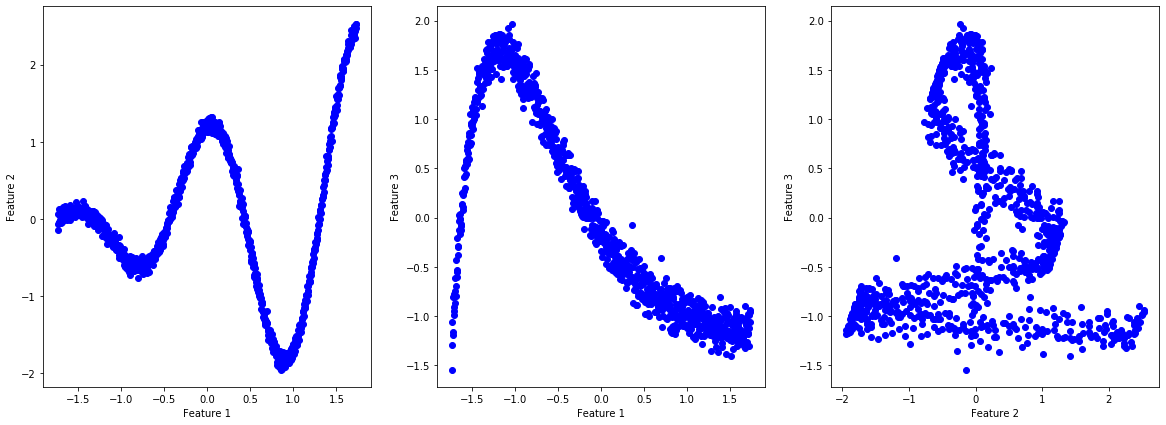

In [6]:
plots_dataset(X_tc)

In [7]:
Z_dim,c_dim,h_dim,X_dim = [30,10,50,X_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden1 = torch.nn.Linear(Z_dim + c_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,c):
        h = F.relu(self.hidden1(torch.cat((z,c),dim=1)))
        h = F.relu(self.hidden2(h))
        X = self.out(h)
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.hidden2 = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        h2 = F.relu(self.hidden2(h))
        y = torch.sigmoid(self.out(h2))
        head = self.hidden2(h)
        return y, head

class QNet(torch.nn.Module):
    def __init__(self):
        super(QNet,self).__init__()
        self.hidden = torch.nn.Linear(h_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 10)
    
    def forward(self,head):
        h = F.relu(self.hidden(head))
        c = torch.softmax(self.out(h),dim=1)
        return c

# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()
Q = QNet().cuda()
# Definimos os otimizadores
lrg,lrd,lrq = [1e-3,1e-3,1e-3]
beta = 0.5
G_optim = optim.Adam(G.parameters(), lr=lrg, betas=(beta,0.999))
D_optim = optim.Adam(D.parameters(), lr=lrd, betas=(beta,0.999))
Q_optim = optim.Adam(Q.parameters(), lr=lrq, betas=(beta,0.999))

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    Q_optim.zero_grad()

def Q_loss_func(c_expected, c):
    return torch.mean(-torch.sum(c * torch.log(c_expected + 1e-8), dim=1)) + 3

def entropy(x):
    return -1*(torch.softmax(x, dim=1) * torch.log_softmax(x, dim=1)).sum()

D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()


    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).cuda()
        m.bias.data.fill_(0.001)  
    
#Inicializar pesos das redes
G.apply(init_weights)
D.apply(init_weights)
Q.apply(init_weights)

batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()

G_his, D_his, D_real_his, D_fake_his, Q_his = [[],[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his,Q_his] 

In [8]:
%%time
epochs = 5000

for epoch in range(epochs):
    # Amostragem de dados
    z = noise(batch, Z_dim).cuda()
    c = noise_uniform(batch,c_dim).cuda()
    X = X_tc.cuda()

    # Dicriminador
    G_sample = G(z,c)
    D_real = D(X)[0]
    D_fake, X_hidden = D(G_sample)
    Q_loss = Q_loss_func(Q(X_hidden),c)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward(retain_graph=True)
    D_optim.step()
#     reset_grad()

    # Q network
    Q_loss = Q_loss_func(Q(X_hidden),c)
    Q_loss.backward()
    Q_optim.step()
    reset_grad()

    # Generador
    z = noise(batch, Z_dim).cuda()
    c = noise_uniform(batch,c_dim).cuda()
    G_sample = G(z,c)
    D_fake, X_hidden = D(G_sample)
    Q_loss = Q_loss_func(Q(X_hidden),c)
    G_loss = G_loss_func(D_fake, ones) + Q_loss
    G_loss.backward()
    G_optim.step()
    reset_grad()

    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    Q_his.append(Q_loss.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/8) == 0 and epoch > 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f} | Average D_fake: {:.5f} | Average Q_loss: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data, Q_loss.data))
        check_c_accuracy(30000,Q,G,D,Z_dim,c_dim)
        nets_test(30000,G,D,Z_dim,c_dim)
        print('-'*100)

Epoch-625| Average D_loss: 1.03618| Average G_loss: 4.22952| Average D_real: 0.54025 | Average D_fake: 0.49592 | Average Q_loss: 3.13617
Q accuracy  96.79%
Average D_real  0.617385| Std D_real  0.196246
Average D_fake  0.383098| Std D_fake  0.152808
----------------------------------------------------------------------------------------------------
Epoch-1250| Average D_loss: 1.29852| Average G_loss: 3.78591| Average D_real: 0.64217 | Average D_fake: 0.65635 | Average Q_loss: 3.01399
Q accuracy  99.90%
Average D_real  0.527540| Std D_real  0.098136
Average D_fake  0.465625| Std D_fake  0.089950
----------------------------------------------------------------------------------------------------
Epoch-1875| Average D_loss: 1.31749| Average G_loss: 3.78538| Average D_real: 0.67062 | Average D_fake: 0.64687 | Average Q_loss: 3.00983
Q accuracy  99.96%
Average D_real  0.528627| Std D_real  0.119488
Average D_fake  0.472899| Std D_fake  0.106846
----------------------------------------------

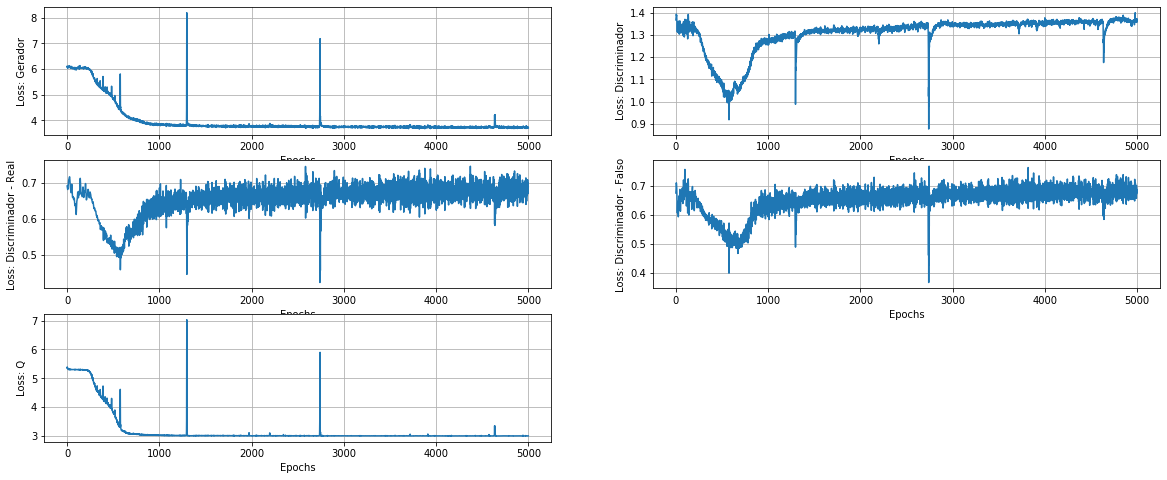

In [9]:
plot_losses(losses_his)

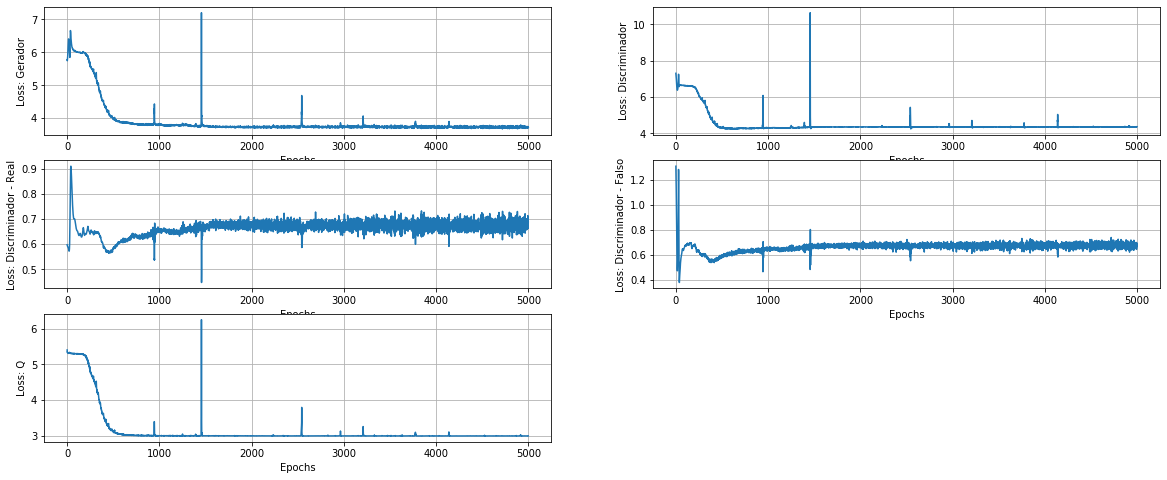

In [90]:
plot_losses(losses_his)

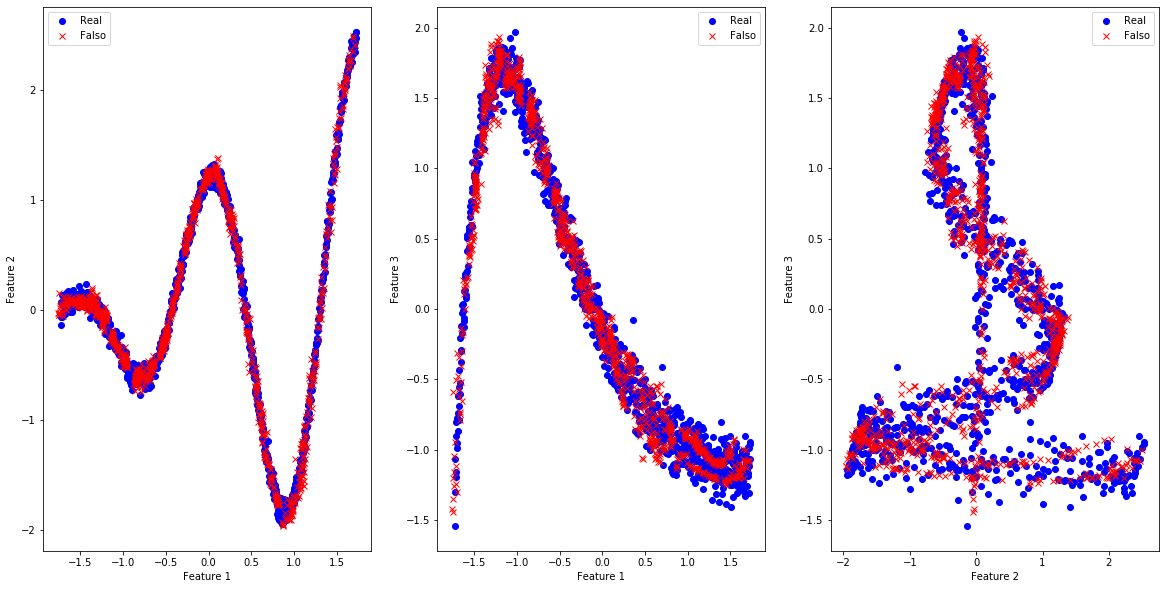

In [10]:
batch_test = 1000
z = noise(batch_test, Z_dim).cuda()
c = noise_uniform(batch_test,c_dim).cuda()
G_sample_plot = G(z,c).cpu()
plots_dims(X_tc,G_sample_plot)

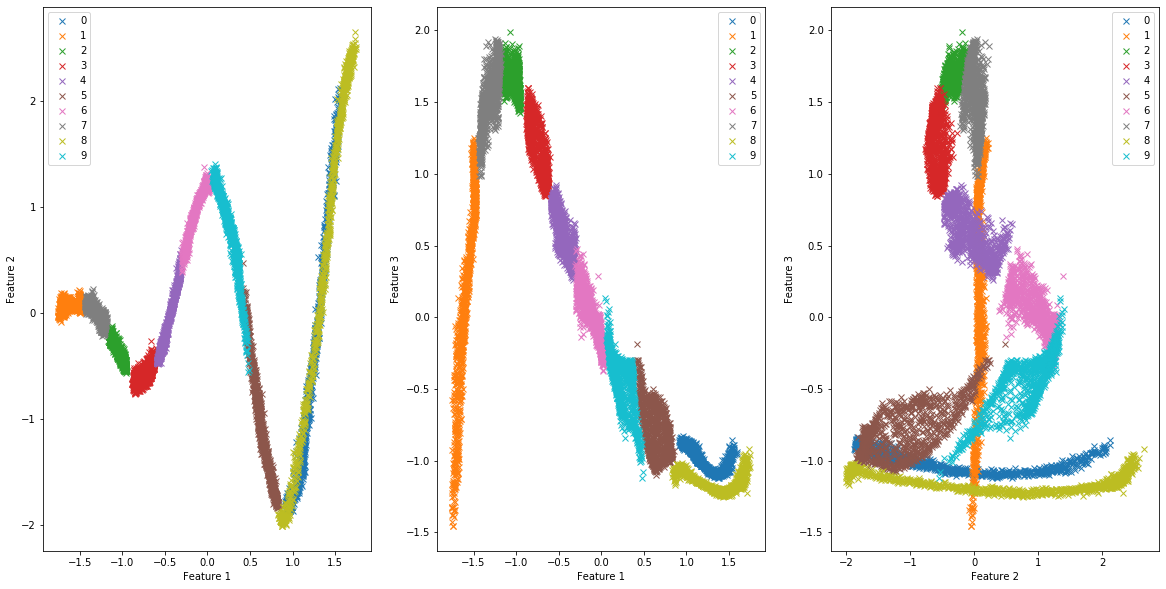

In [11]:
plots_dims_with_cs(X_tc)

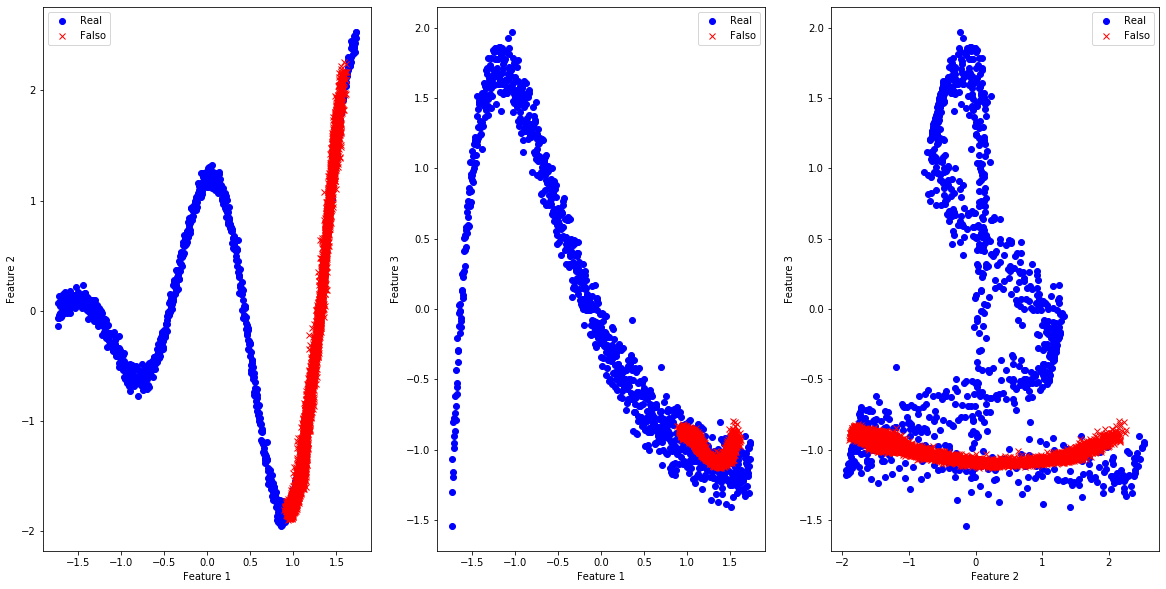

In [12]:
plots_dims(X_tc,get_X_from_c(label=0,batch=5000))

* Avaliando o resultado

In [25]:
z = Variable(torch.randn(1000, Z_dim))
X_fake = G(z)

In [31]:
# DataFrame real
df_real = pd.DataFrame(data=X_data,columns=['x1','x2','x3'])
df_real['reality_label'] = 1
# DataFrame falso
df_fake = pd.DataFrame(data=X_fake.data.numpy(),columns=['x1','x2','x3'])
df_fake['reality_label'] = 0
# Concatemos e embaralhamos os dois
df_mixed = pd.concat([df_real,df_fake],axis=0)
df_mixed = df_mixed.sample(frac=1.0)
# Separamos o label para ser o target
X_mixed = df_mixed.drop('reality_label',axis=1).copy()
y_mixed = df_mixed['reality_label'].copy()
# Transformamos em tensores
X_mix_tc = torch.Tensor(X_mixed.values).type(torch.FloatTensor)
y_mix_tc = torch.Tensor(y_mixed.values).type(torch.FloatTensor)

In [35]:
# Previsão
y_predict = D(X_mix_tc)

In [36]:
print("Confusion Matrix:")
print(confusion_matrix(y_mix_tc.data.numpy().reshape(2000,),np.round(y_predict.data.numpy().reshape(2000,),0)))

Confusion Matrix:
[[404 596]
 [397 603]]


In [37]:
print("Classification Report:")
print(classification_report(y_mix_tc.data.numpy().reshape(2000,),np.round(y_predict.data.numpy().reshape(2000,),0),digits=5))

Classification Report:
              precision    recall  f1-score   support

         0.0    0.50437   0.40400   0.44864      1000
         1.0    0.50292   0.60300   0.54843      1000

    accuracy                        0.50350      2000
   macro avg    0.50364   0.50350   0.49854      2000
weighted avg    0.50364   0.50350   0.49854      2000

